In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/V1_PYTHON/CDKL5_T1/"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

ANCHOR = root_search_path.split(os.sep)[-3]  # anything before project name
def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if ANCHOR in parts:
            idx = parts.index(ANCHOR)

            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "Chip_ID", "RunID", "Well"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
print(df.head())

# 5. SAVE
df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index_networks.csv", index=False)

 dissecting path names...
Successfully dissected 396 paths.

Snapshot of extracted metadata:
    Project    Date Chip_ID   RunID     Well  \
0  CDKL5_T1  240607  M08018  000095  well000   
1  CDKL5_T1  240607  M08018  000095  well003   
2  CDKL5_T1  240607  M08018  000095  well004   
3  CDKL5_T1  240607  M08018  000095  well001   
4  CDKL5_T1  240607  M08018  000095  well002   

                                           full_path  
0  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
1  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
2  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
3  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
4  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  


In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['mean_firing_rate', 'mean_burst_rate', 'network_burst_frequency', 'burst_duration_mean']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- burstlets: (Nested Dictionary)
  - events: List [510 items]
  - metrics: (Nested Dictionary)
    - count: int (e.g., 510)
    - rate: float (e.g., 1.6995496193508721)
    - duration: (Nested Dictionary)
      - mean: float (e.g., 0.2255254901962256)
      - std: float (e.g., 0.11395283689553914)
      - cv: float (e.g., 0.5052769724450699)
    - inter_event_interval: (Nested Dictionary)
      - mean: float (e.g., 0.5887021611005807)
      - std: float (e.g., 0.9434192929836135)
      - cv: float (e.g., 1.602540903230061)
    - intensity: (Nested Dictionary)
      - mean: float (e.g., 52.30210530249471)
      - std: float (e.g., 33.51765990125623)
      - cv: float (e.g., 0.6408472413759128)
    - participation: (Nested Dictionary)
      - mean: float (e.g., 0.6525786457724243)
      - std: float (e.g., 0.17146600910925422)
      - cv: float (e.g., 0.2627514863075217)
    - spikes_per_burst: (Nested Dictionary)
      - mean: float (e.g., 3189.774509803922)


In [3]:
import json
import pandas as pd
import numpy as np
import os

# --- 1. SETUP & PROGRESS BAR ---
try:
    from tqdm import tqdm
    tqdm.pandas()
    # Assuming 'df' is your existing dataframe with file paths
    print("Progress bar enabled.")
except ImportError:
    def tqdm(x, **kwargs): return x
    print("Install 'tqdm' for a progress bar. Running standard loop...")
def extract_metrics(row):
    path = row['full_path']

    metrics = {
        # -------- Network Bursts (NB) --------
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,
        "nb_ibi_mean_s": np.nan,
        "nb_spikes_per_burst_mean": np.nan,
        "nb_participation_mean": np.nan,

        "nb_durations_list": [],
        "nb_peak_list": [],
        "nb_intensity_list": [],
        "nb_synchrony_energy_list": [],

        # -------- Superbursts (SB) --------
        "sb_count": np.nan,
        "sb_rate_hz": np.nan,
        "sb_duration_mean_s": np.nan,
        "sb_ibi_mean_s": np.nan,
        "sb_spikes_per_burst_mean": np.nan,
        "sb_participation_mean": np.nan,

        "sb_durations_list": [],
        "sb_peak_list": [],
        "sb_intensity_list": [],
        "sb_synchrony_energy_list": [],

        # -------- Burstlets (BL) --------
        "bl_count": np.nan,
        "bl_rate_hz": np.nan,
        "bl_duration_mean_s": np.nan,
        "bl_ibi_mean_s": np.nan,
        "bl_spikes_per_burst_mean": np.nan,
        "bl_participation_mean": np.nan,


        "bl_durations_list": [],
        "bl_peak_list": [],
        "bl_intensity_list": [],   
        "bl_synchrony_energy_list": [],
        "num_units": np.nan,
    }

    try:
        with open(path, "r") as f:
            data = json.load(f)

        # ---------- Helper ----------
        def extract_block(block, prefix):
            if block is None:
                return

            m = block.get("metrics", {})
            events = block.get("events", [])

            metrics[f"{prefix}_count"] = m.get("count", np.nan)

            if "rate_bpm" in m:
                metrics[f"{prefix}_rate_hz"] = m["rate_bpm"] / 60.0

            metrics[f"{prefix}_duration_mean_s"] = m.get("duration", {}).get("mean")
            metrics[f"{prefix}_ibi_mean_s"] = m.get("inter_event_interval", {}).get("mean")
            metrics[f"{prefix}_spikes_per_burst_mean"] = m.get("spikes_per_burst", {}).get("mean")
            metrics[f"{prefix}_participation_mean"] = m.get("participation", {}).get("mean")

            # --- Raw Distributions ---
            for ev in events:
                if "duration_s" in ev:
                    metrics[f"{prefix}_durations_list"].append(ev["duration_s"])
                if "peak_synchrony" in ev:
                    metrics[f"{prefix}_peak_list"].append(ev["peak_synchrony"])
                if "synchrony_energy" in ev:
                    metrics[f"{prefix}_synchrony_energy_list"].append(ev["synchrony_energy"])
                if "total_spikes" in ev:
                    metrics[f"{prefix}_intensity_list"].append(ev["total_spikes"])
                
                
                

        # ---------- Apply ----------
        extract_block(data.get("network_bursts"), "nb")
        extract_block(data.get("superbursts"), "sb")
        extract_block(data.get("burstlets"), "bl")
        # Number of units
        metrics["num_units"] = data["n_units"]

    except Exception as e:
        print(f"[ERROR] {path}: {e}")

    return pd.Series(metrics)

# --- 3. RUN EXTRACTION ---
print("Starting unified extraction (Scalars + Lists)...")

# If you have tqdm installed, use progress_apply, otherwise use apply
if hasattr(tqdm, 'pandas'):
    df_metrics = df.progress_apply(extract_metrics, axis=1)
else:
    df_metrics = df.apply(extract_metrics, axis=1)

# Concatenate metadata with results
result_df = pd.concat([df, df_metrics], axis=1)



Progress bar enabled.
Starting unified extraction (Scalars + Lists)...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396/396 [00:07<00:00, 52.54it/s]


In [4]:
print(result_df.columns)

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_durations_list', 'nb_peak_list', 'nb_intensity_list',
       'nb_synchrony_energy_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_durations_list', 'bl_peak_list', 'bl_intensity_list',
       'bl_synchrony_energy_list', 'num_units'],
      dtype='object')


In [5]:
import pandas as pd

ref_df = pd.read_excel("/pscratch/sd/m/mpatil1/Data/CDKL5_T1/CDKL5_T1_C1_reff_new.xlsx")
print(ref_df.columns)

# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')

# Step B: Explode the lists into rows (keeps alignment)
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])

# Step C: Cleanup
exploded_df['Well'] = exploded_df['Wells_List'].str.strip()
exploded_df['NeuronType'] = exploded_df['Source_List'].str.strip()

# Step D: FIX — convert 1-based wells to 0-based and format
exploded_df['Well'] = (
    'well'
    + (exploded_df['Well'].astype(int) - 1)
      .astype(str)
      .str.zfill(3)
)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #', 'Well', 'NeuronType', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print("Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save if needed
# clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source'],
      dtype='object')
Transformation complete.
Original rows: 79
Exploded rows: 474

First 10 rows of clean metadata:
        Date      ID  Run #     Well NeuronType          Assay  DIV
0 2024-05-20  M07420      1  well000       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well001       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well002       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well003      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well004      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well005      FxHET       Sparse7x    5
1 2024-05-20  M07420      2  well000       MxWT  Network Today    5
1 2024-05-20  M07420      2  well001       MxWT  Network Today    5
1 2024-05-20  M07420      2  well002       MxWT  Network Today    5
1 2024-05-20  M07420      2  well003      FxHET  Network Today    5


In [6]:
clean_ref_df.columns

Index(['Date', 'ID', 'Run #', 'Well', 'NeuronType', 'Assay', 'DIV'], dtype='object')

In [7]:
clean_ref_df['Date'] = (
    pd.to_datetime(clean_ref_df['Date'])
      .dt.strftime('%y%m%d')
)

/tmp/ipykernel_1934769/3958324485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ref_df['Date'] = (


In [8]:
result_df.columns

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_durations_list', 'nb_peak_list', 'nb_intensity_list',
       'nb_synchrony_energy_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_durations_list', 'bl_peak_list', 'bl_intensity_list',
       'bl_synchrony_energy_list', 'num_units'],
      dtype='object')

In [9]:
result_df.rename(columns={"RunID": "Run #","Chip_ID": "ID"}, inplace=True)

In [10]:
result_df['Date'] = result_df['Date'].astype(str)

In [11]:
result_df['Run #'] = result_df['Run #'].astype(str).str.zfill(6)
clean_ref_df['Run #'] = clean_ref_df['Run #'].astype(str).str.zfill(6)

/tmp/ipykernel_1934769/2122106171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ref_df['Run #'] = clean_ref_df['Run #'].astype(str).str.zfill(6)


In [12]:
print(result_df['Well'].unique()[:10])
print(clean_ref_df['Well'].unique()[:10])

['well000' 'well003' 'well004' 'well001' 'well002' 'well005']
['well000' 'well001' 'well002' 'well003' 'well004' 'well005']


In [13]:
# JSON-derived table must be unique
assert not result_df.duplicated(
    ['ID','Date','Run #','Well']
).any(), "Duplicate JSON-derived rows detected"

# Metadata table must be unique
assert not clean_ref_df.duplicated(
    ['ID','Date','Run #','Well']
).any(), "Duplicate metadata rows detected"

In [14]:
merged_df = pd.merge(
    result_df,
    clean_ref_df,
    how='left',
    on=['ID', 'Date', 'Run #', 'Well'],
    validate='one_to_one'
)

In [15]:
#order by run #
merged_df.sort_values(by=['ID', 'Run #', 'Well'], inplace=True)

In [16]:
merged_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_spikes_per_burst_mean,bl_participation_mean,bl_durations_list,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,num_units,NeuronType,Assay,DIV
246,CDKL5_T1,240520,M07039,000006,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,54,NaN,1.018889,5.540377,...,1238.628571,0.342451,"[2.07, 0.7800000000000011, 0.629999999999999, ...","[638.6071641919644, 31.754702074483745, 20.613...","[16103, 543, 330, 1731, 401, 1050, 518, 355, 2...","[297.3891379909399, 15.525469946979879, 9.7792...",1019,MxHEMI,Network Today,5.0
249,CDKL5_T1,240520,M07039,000006,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,61,NaN,0.855738,4.881000,...,429.588889,0.293581,"[0.5099999999999998, 0.41999999999999993, 0.44...","[23.660957974407214, 25.942188569266996, 24.47...","[368, 322, 325, 331, 291, 232, 499, 382, 447, ...","[10.517221729821893, 9.180384381857161, 9.3489...",791,MxWT,Network Today,5.0
250,CDKL5_T1,240520,M07039,000006,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,65,NaN,0.961846,4.404844,...,453.514851,0.309074,"[0.5999999999999996, 0.4200000000000017, 0.510...","[23.8994183794986, 18.733564278971226, 19.4027...","[360, 229, 235, 490, 457, 197, 287, 260, 310, ...","[10.047900884975078, 6.618187504048706, 7.2319...",582,FxHET,Network Today,5.0
247,CDKL5_T1,240520,M07039,000006,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,20,NaN,0.943500,13.908947,...,2134.461538,0.421292,"[1.17, 0.4499999999999993, 0.11999999999999744...","[553.8194319717786, 56.60174029190051, 50.2670...","[11590, 602, 211, 634, 418, 2901, 2092, 842, 8...","[206.55692968774792, 14.175576482323175, 5.163...",819,MxHEMI,Network Today,5.0
248,CDKL5_T1,240520,M07039,000006,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,51,NaN,0.812353,5.824800,...,356.154930,0.245174,"[0.5099999999999998, 0.6000000000000014, 0.570...","[20.65210365143063, 23.904670873125482, 19.741...","[300, 371, 324, 285, 319, 241, 249, 300, 327, ...","[8.345250663842375, 10.60625355476981, 9.69102...",761,MxWT,Network Today,5.0


In [17]:
merged_df['Date'].dtype

dtype('O')

In [18]:
plating_date = '240515'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days

In [19]:
merged_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_durations_list', 'nb_peak_list', 'nb_intensity_list',
       'nb_synchrony_energy_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_durations_list', 'bl_peak_list', 'bl_intensity_list',
       'bl_synchrony_energy_list', 'num_units', 'NeuronType', 'Assay', 'DIV'],
      dtype='object')

In [20]:
merged_df.to_excel("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_combined_metrics_CDKL5_T1_PythonV1.xlsx", index=False)

## Graphs as it is

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind


def plot_scalar_line_ttest_vs_control(
    df,
    value_col,
    control_group='MxWT',
    feature_label=None,
    order=('MxWT', 'FxHET', 'MxHEMI'),
    palette={'MxWT': '#1f77b4', 'FxHET': '#c77b1b', 'MxHEMI': '#d62728'},
    save_path=None
):
    """
    Lineplot comparing groups vs control.

    ASSUMPTION (CRITICAL):
    - Each row = one well (biological replicate) at one DIV
    - No technical replicates inside a well
    """
    DIV_to_exclude =[5]
    # ------------------------------------------------------------
    # 0. X-AXIS GEOMETRY CONTROL
    # ------------------------------------------------------------
    DIV_SPACING  = 1.6    # spacing between DIVs
    GENO_SPACING = 0.15   # spacing between genotypes within DIV

    # ------------------------------------------------------------
    # 1. PREP DATA (NO AGGREGATION HERE)
    # ------------------------------------------------------------
    req_cols = {'DIV', 'NeuronType', 'ID', 'Well', value_col}
    missing = req_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    sub = df[list(req_cols)].copy()
    sub = sub.dropna(subset=[value_col])

    # unique biological replicate ID (for sanity checks only)
    sub['ChipID_Well'] = sub['ID'].astype(str) + '_W' + sub['Well'].astype(str)

    # ------------------------------------------------------------
    # 1a. SANITY CHECKS (FAIL FAST)
    # ------------------------------------------------------------
    # dup_check = (
    #     sub.groupby(['DIV', 'ChipID_Well', 'NeuronType'])
    #     .size()
    #     .reset_index(name='n')
    # )

    # if (dup_check['n'] > 1).any():
    #     raise RuntimeError(
    #         "Multiple rows detected per (DIV, ChipID_Well, NeuronType).\n"
    #         "You are double-counting replicates.\n"
    #         "Either aggregate explicitly OR fix upstream data."
    #     )

    # ------------------------------------------------------------
    # 2. SUMMARY STATS (BIOLOGICAL REPLICATES ONLY)
    # ------------------------------------------------------------
    summary = (
        sub
        .groupby(['DIV', 'NeuronType'], as_index=False)
        .agg(
            mean_value=(value_col, 'mean'),
            sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),
            n_wells=(value_col, 'count')
        )
    )

    divs = sorted(summary['DIV'].unique())
    if DIV_to_exclude:
        divs = [d for d in divs if d not in DIV_to_exclude]
    # categorical x positions
    div_to_x = {div: i * DIV_SPACING for i, div in enumerate(divs)}

    # genotype offsets
    group_offsets = {
        g: (i - (len(order) - 1) / 2) * GENO_SPACING
        for i, g in enumerate(order)
    }

    # ------------------------------------------------------------
    # 3. ROBUST Y LIMITS (DISPLAY ONLY)
    # ------------------------------------------------------------
    yvals = sub[value_col].values
    yvals = yvals[np.isfinite(yvals)]

    if yvals.size < 2:
        print(f"[SKIP] {value_col}: insufficient finite data")
        return


    y_low = np.nanpercentile(yvals, 1)
    y_high = np.nanpercentile(yvals, 99)

    if not np.isfinite(y_low) or not np.isfinite(y_high):
        print(f"[SKIP] {value_col}: invalid y-limits")
        return

    if y_high <= y_low:
        # flat or near-flat feature
        pad = 0.1 * (abs(y_high) if y_high != 0 else 1.0)
        y_low -= pad
        y_high += pad

    yrange = y_high - y_low
    # ------------------------------------------------------------
    # 4. FIGURE
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 4.8))
    ax.set_ylim(y_low, y_high + 0.05 * yrange)

    # ------------------------------------------------------------
    # 5. SCATTER + LOLLIPOP OUTLIERS (RAW DATA)
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = sub[sub['NeuronType'] == nt]
        offset = group_offsets[nt]
        jitter = (np.random.rand(len(sub_nt)) - 0.5) * 0.12

        x = sub_nt['DIV'].map(div_to_x) + offset + jitter
        y = sub_nt[value_col]

        mask_in = y <= y_high
        mask_out = y > y_high

        ax.scatter(
            x[mask_in],
            y[mask_in],
            s=18,
            alpha=0.25,
            color=palette[nt],
            edgecolor='none',
            zorder=1
        )

        if mask_out.any():
            ax.scatter(
                x[mask_out],
                np.full(mask_out.sum(), y_high),
                marker='^',
                s=40,
                color=palette[nt],
                alpha=0.85,
                zorder=4
            )

    # ------------------------------------------------------------
    # 6. MEAN ± SEM LINES
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = summary[summary['NeuronType'] == nt]
        x = sub_nt['DIV'].map(div_to_x) + group_offsets[nt]

        ax.plot(
            x,
            sub_nt['mean_value'],
            '-o',
            lw=2.5,
            color=palette[nt],
            label=nt,
            zorder=3
        )

        ax.fill_between(
            x,
            sub_nt['mean_value'] - sub_nt['sem_value'],
            sub_nt['mean_value'] + sub_nt['sem_value'],
            color=palette[nt],
            alpha=0.12,
            zorder=2
        )

    # ------------------------------------------------------------
    # 7. STATS (WELL-LEVEL, WT VS MUTANTS)
    # ------------------------------------------------------------
    sig_results = []

    for div in divs:
        day_data = sub[sub['DIV'] == div]

        ctrl = day_data[
            day_data['NeuronType'] == control_group
        ][value_col]

        if len(ctrl) < 2:
            continue

        for group in order:
            if group == control_group:
                continue

            exp = day_data[
                day_data['NeuronType'] == group
            ][value_col]

            if len(exp) < 2:
                continue

            _, p = ttest_ind(
                ctrl, exp,
                equal_var=False,
                nan_policy='omit'
            )

            if p < 0.05:
                sig_results.append((div, group, p))

    # ------------------------------------------------------------
    # 8. INLINE SIGNIFICANCE STARS
    # ------------------------------------------------------------
    for div, group, p in sig_results:
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*'

        y = summary[
            (summary['DIV'] == div) &
            (summary['NeuronType'] == group)
        ]['mean_value'].values

        if len(y) == 0:
            continue

        x = div_to_x[div] + group_offsets[group]
        y0 = y[0]
        dy = yrange * 0.035

        ax.plot([x, x], [y0, y0 + dy * 0.8], lw=1, color='k', zorder=4)
        ax.text(
            x, y0 + dy, sig,
            ha='center', va='bottom',
            fontsize=12, fontweight='bold',
            color='k', zorder=5
        )

    # ------------------------------------------------------------
    # 9. FINAL POLISH
    # ------------------------------------------------------------
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or value_col, weight='bold')

    ax.set_xticks([div_to_x[d] for d in divs])
    ax.set_xticklabels(divs)

    ax.legend(
        title='Genotype',
        frameon=False,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path:
        dir = os.path.dirname(save_path)
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path, dpi=300, format='svg')
    plt.show()

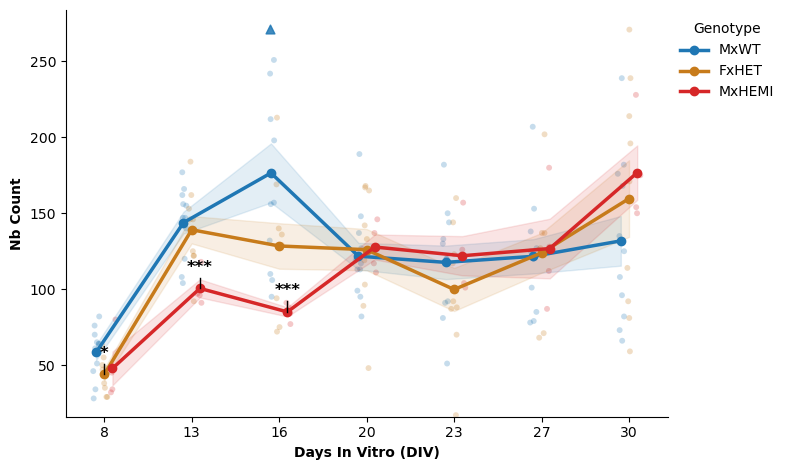

[SKIP] nb_rate_hz: insufficient finite data


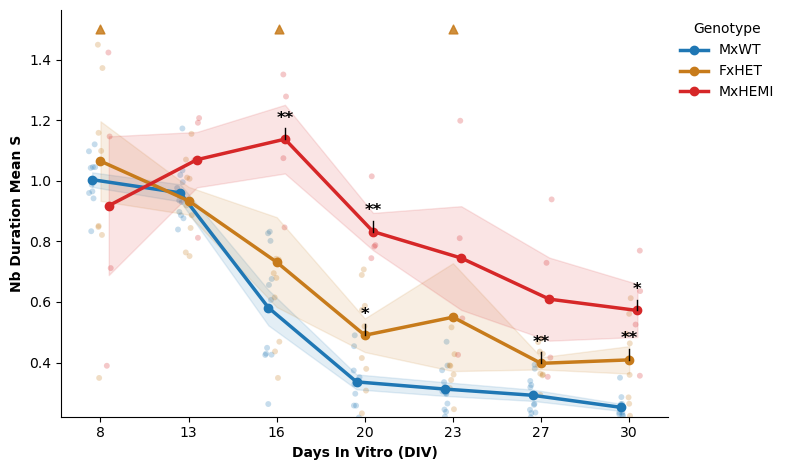

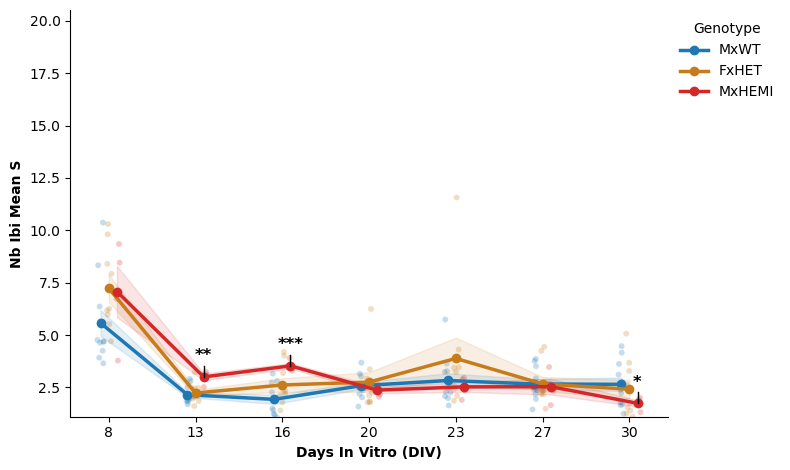

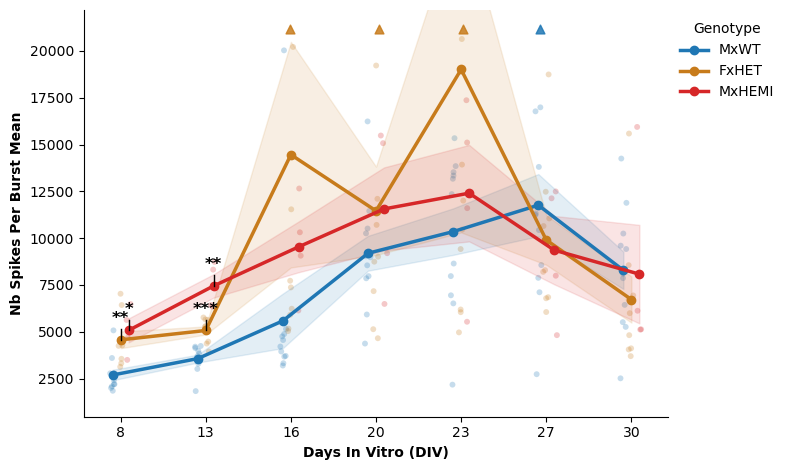

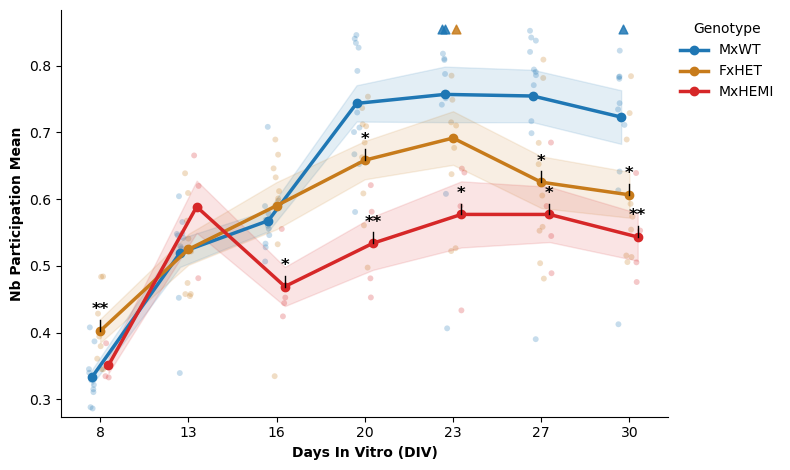

/tmp/ipykernel_1934769/439651336.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),
/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


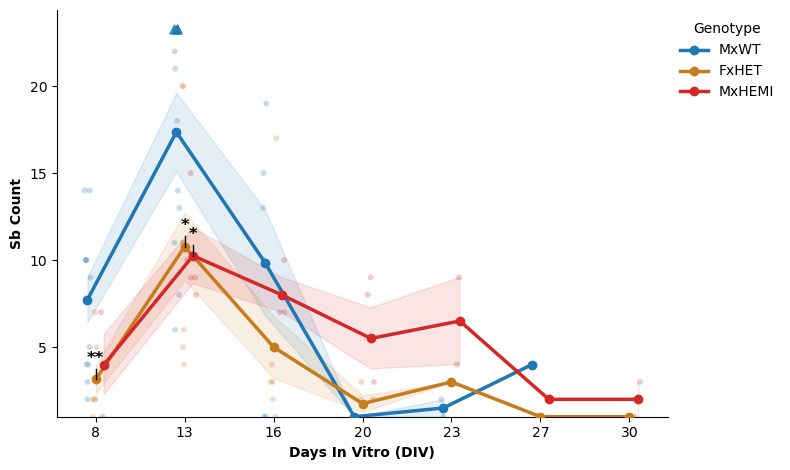

/tmp/ipykernel_1934769/439651336.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),


[SKIP] sb_rate_hz: insufficient finite data


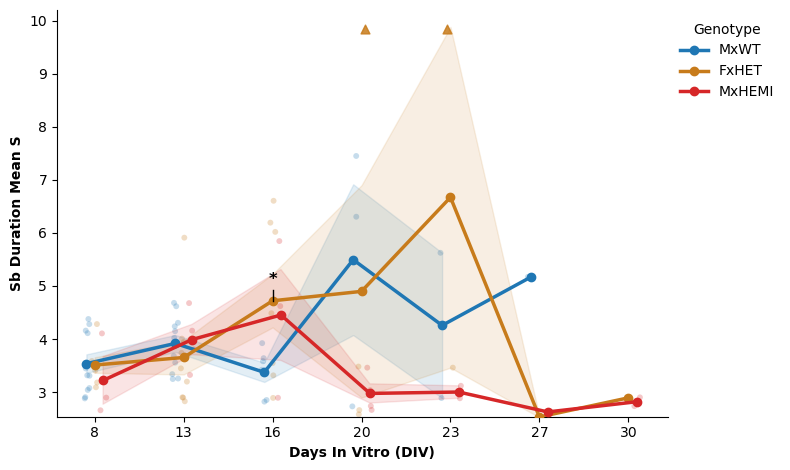

/tmp/ipykernel_1934769/439651336.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),


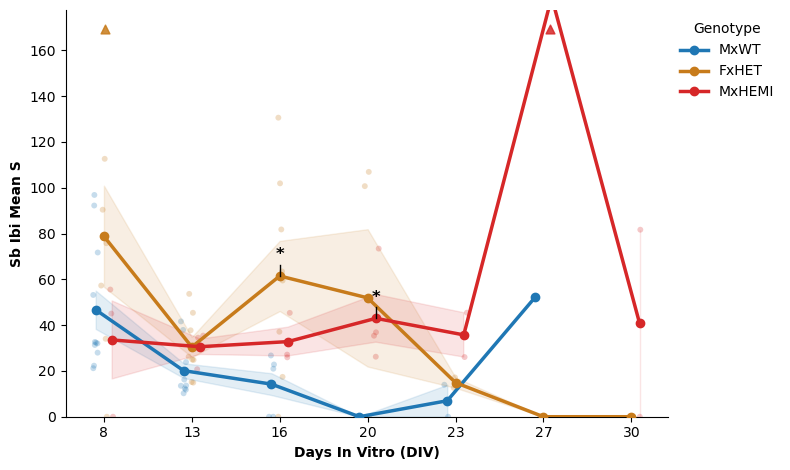

/tmp/ipykernel_1934769/439651336.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),


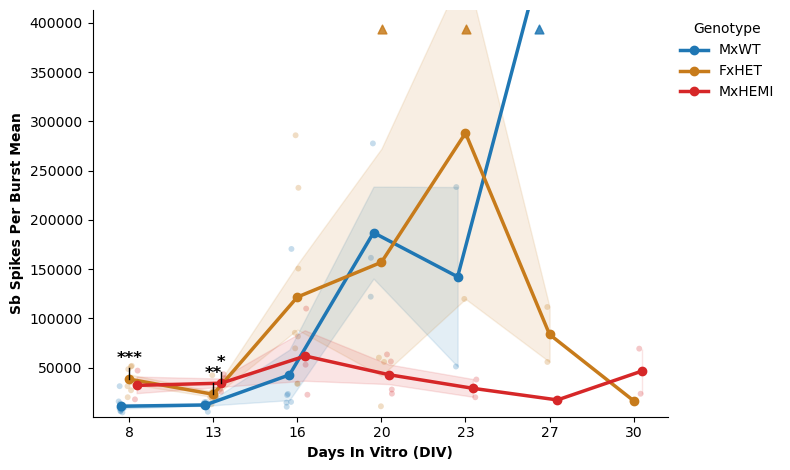

/tmp/ipykernel_1934769/439651336.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),


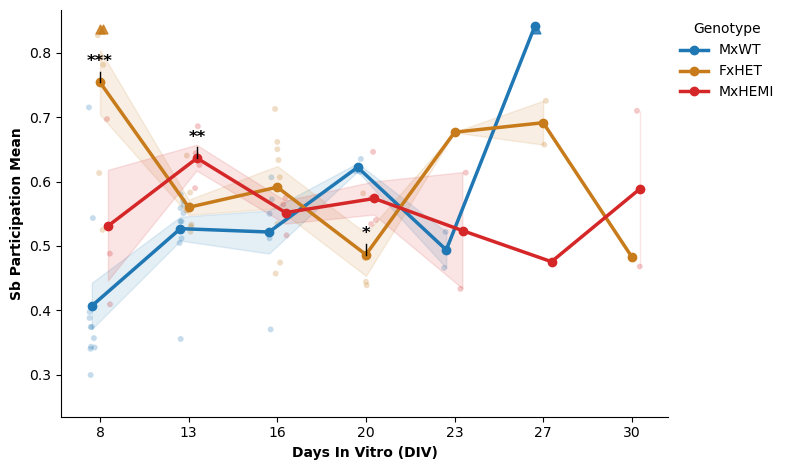

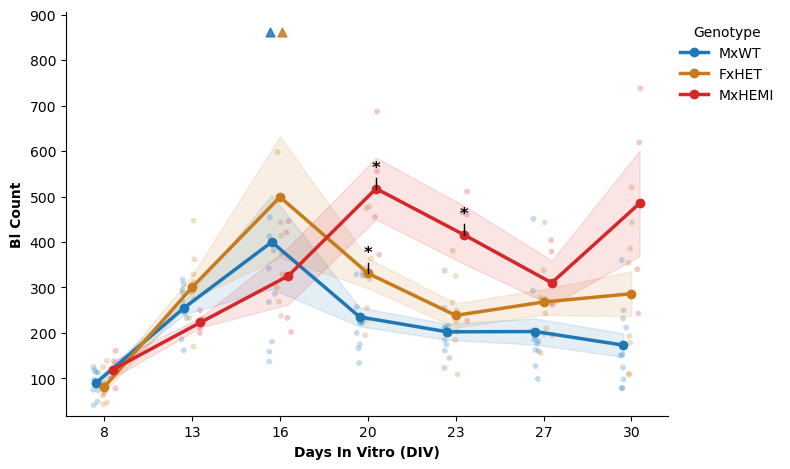

[SKIP] bl_rate_hz: insufficient finite data


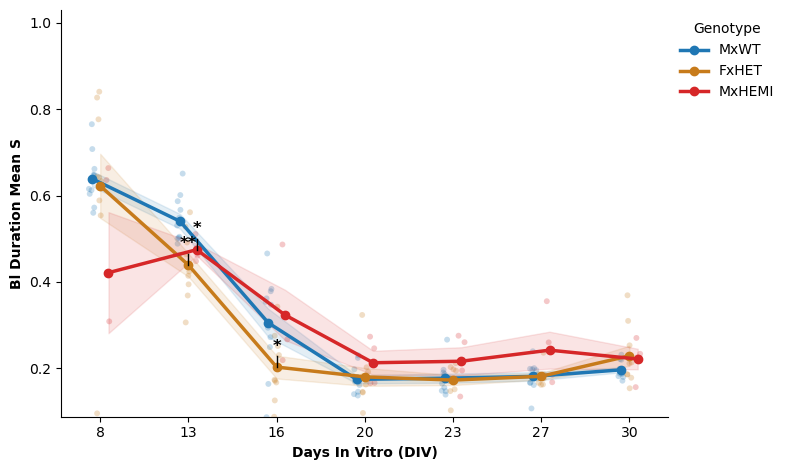

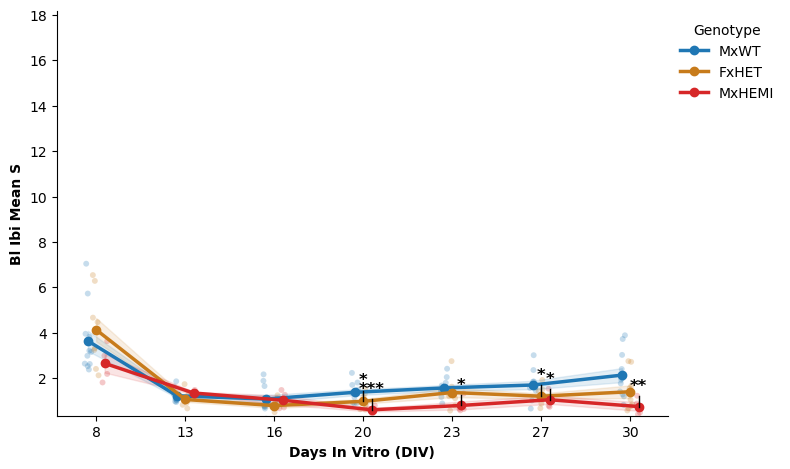

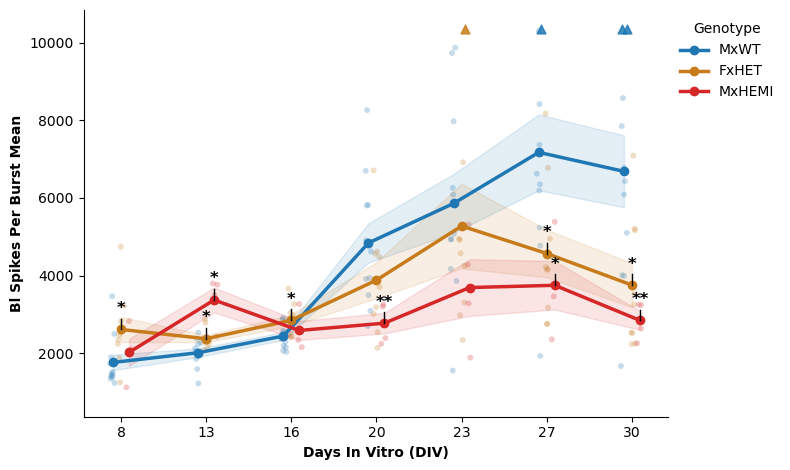

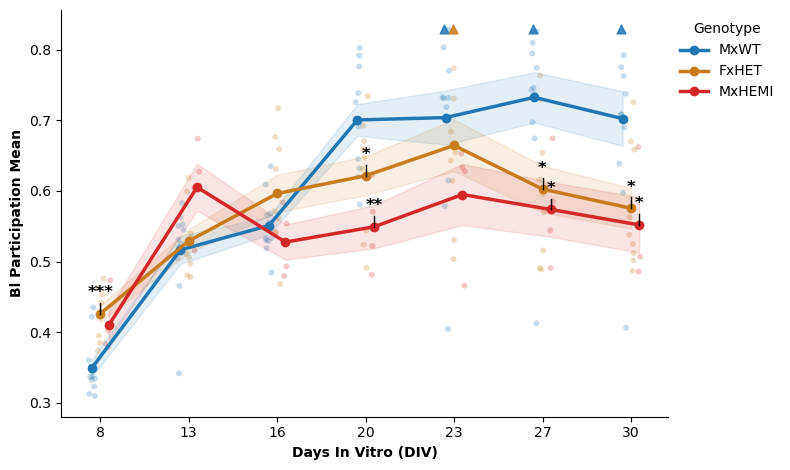

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


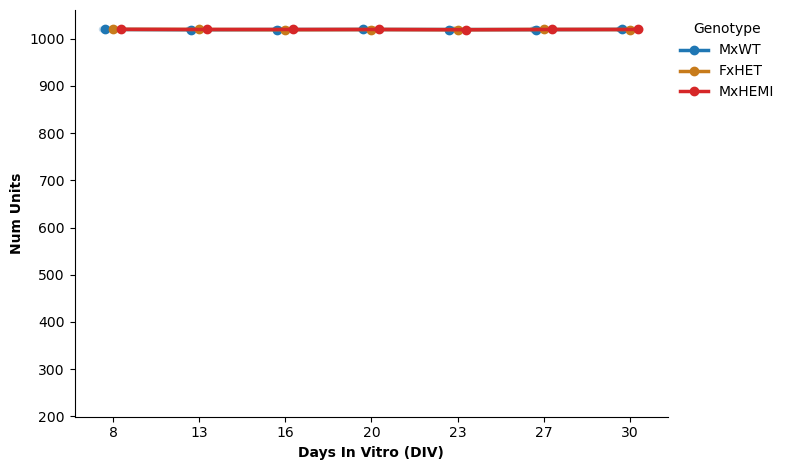

In [34]:
cols_to_plot = [ 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
     'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
        'num_units'
       ]
for col in cols_to_plot:
    plot_scalar_line_ttest_vs_control(
        merged_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
        save_path=f"/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/plots/{col}_lineplot.svg"
    )


## Graphs ylim CUTOOF